# 모델의 종류에 따른 노이즈 데이터 특징 학습 변화 분석

노이즈 종류에 따라 드리프트 현상이 모델에 미치는 영향도의 양상이 모델에 따라 달라질 수 있는가 실험

## 실험 대상 데이터

각 타입의 노이즈 적용 데이터셋 및 복합 노이즈 데이터셋

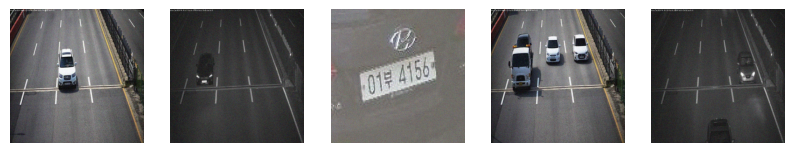

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

noise_types = ['gaus', 'snp', 'motion_blur', 'jpeg_compression', 'bright', 'dark', 'noise_composite']

test_dataset_path = f"../datasets/{noise_types[0]}_current/images/train/"
# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(test_dataset_path) if os.path.isfile(os.path.join(test_dataset_path, f))]

# 랜덤하게 5장 선택
random_images = random.sample(image_files, 5)

# 이미지 시각화
plt.figure(figsize=(10, 10))
for i, image_file in enumerate(random_images):
    img = mpimg.imread(os.path.join(test_dataset_path, image_file))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class YoloDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []

        # train, valid, test 디렉토리의 이미지 파일을 모두 수집
        for phase in ['train', 'val', 'test']:
            phase_dir = os.path.join(root_dir, 'images', phase)
            self.image_files.extend(
                [os.path.join(phase_dir, f) for f in os.listdir(phase_dir) if f.endswith('.jpg')]
            )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')

        # 이미지 로드
        image = Image.open(img_path).convert('RGB')

        # 라벨 로드
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                boxes.append([x_center, y_center, width, height])
                labels.append(class_id)

        # 변환 적용
        if self.transform:
            image = self.transform(image)

        # 바운딩 박스와 라벨을 텐서로 변환
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return image, {'boxes': boxes, 'labels': labels}
    
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

In [11]:
# 데이터셋 경로 설정
test_dir = "../datasets/gaus_current"

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # 이미지 크기를 640x640으로 조정
    transforms.ToTensor(),
])

# 데이터셋 및 데이터로더 생성
yolo_dataset = YoloDataset(test_dir, transform=transform)
train_dataloader = DataLoader(yolo_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# 데이터 확인
for images, targets in train_dataloader:
    print(len(images))
    print(targets)
    break

4
[{'boxes': tensor([[0.6938, 0.5367, 0.0383, 0.0195],
        [0.8445, 0.0492, 0.0219, 0.0125],
        [0.9609, 0.2672, 0.0273, 0.0156]]), 'labels': tensor([0, 0, 0])}, {'boxes': tensor([[0.2836, 0.1562, 0.0312, 0.0305],
        [0.4031, 0.7602, 0.0469, 0.0242],
        [0.7688, 0.5711, 0.0398, 0.0227],
        [0.9820, 0.2898, 0.0172, 0.0188],
        [0.4602, 0.0055, 0.0203, 0.0094],
        [0.9484, 0.0172, 0.0195, 0.0117]]), 'labels': tensor([0, 0, 0, 0, 0, 0])}, {'boxes': tensor([[0.5078, 0.4977, 0.5508, 0.5953]]), 'labels': tensor([0])}, {'boxes': tensor([[0.4891, 0.5086, 0.6766, 0.4594]]), 'labels': tensor([0])}]
